# Topic modeling

In [66]:
# !pip install -U orjson sqlitedict tomotopy nltk pyLDAvis altair ipywidgets

In [100]:
import os
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from tqdm.auto import tqdm
import orjson
import zlib
import tomotopy as tp
from sqlitedict import SqliteDict
import topicwizard
import random
import pyLDAvis
from collections import Counter
import nltk
from nltk.corpus import stopwords as stops
import numpy as np

In [3]:
# corpus
path_corpus=os.path.expanduser('~/ppa_data/solrcorpus2')
path_metadata = os.path.join(path_corpus, 'metadata.csv')
path_pages = os.path.join(path_corpus, 'corpus.sqlitedict')

In [4]:
# Read metadata
# df_metadata = pd.read_csv(path_metadata).fillna('').set_index('work_id')
# df_metadata

In [5]:
def encode_cache(x): return sqlite3.Binary(zlib.compress(orjson.dumps(x)))
def decode_cache(x): return orjson.loads(zlib.decompress(bytes(x)))
def get_pages_db():
    return SqliteDict(path_pages, flag='r', tablename='texts', encode=encode_cache, decode=decode_cache)
def get_meta_db():
    return SqliteDict(path_pages, flag='r', tablename='metadata', encode=encode_cache, decode=decode_cache)

In [6]:
CLUSTER_KEY='cluster_id_s'

def iter_pages(lim=None,min_num_words=None,max_pages_per_doc=None,max_pages_per_cluster=None, collections={}):
    num=0
    clustercounts=Counter()
    breaknow=False
    with get_pages_db() as db, get_meta_db() as mdb:
        for work_id in tqdm(list(db.keys()),desc='Iterating works',position=0):
            if breaknow: break

            meta = mdb[work_id]
            if collections and not set(meta['collections']) & set(collections):
                continue
            pages = db[work_id]
            cluster = meta.get(CLUSTER_KEY,work_id)

            if min_num_words:
                pages = [d for d in pages if len(d['page_tokens'])>=min_num_words]

            if max_pages_per_doc:
                random.shuffle(pages)
                pages=pages[:max_pages_per_doc]

            pbar2=tqdm(pages,desc='Iterating pages',position=1,disable=True)
            for page in pbar2:
                if not max_pages_per_cluster or clustercounts[cluster]<max_pages_per_cluster:
                    yield dict(
                        work_cluster = cluster,
                        **page
                    )
                    clustercounts[cluster]+=1
                    num+=1
                    if lim and num>=lim:
                        breaknow=True
                        break
            pbar2.close()

def iter_corpus(lim=None,max_pages_per_doc=25,**kwargs):
    yield from iter_pages(lim=lim,min_num_words=25,collections={'Literary','Linguistic'},max_pages_per_doc=max_pages_per_doc,**kwargs)

def iter_sample(lim=None):
    yield from iter_corpus(lim=lim, max_pages_per_cluster=25, max_pages_per_doc=25)

# next(iter_pages(collections=['Linguistic']))
# for x in iter_pages(max_pages_per_cluster=1): pass
# for i,x in enumerate(iter_corpus()): pass
# i
# next(iter_corpus())

In [7]:

stopwords = set(stops.words('english'))
def clean_toks(toks):
    return [tok for tok in toks if len(tok)>3 and tok not in stopwords]

In [8]:
def topic_model(ntopic=50, force=False, niter=100):
    fn=f'data.tomotopy.model.ntopic={ntopic}.bin'
    fnindex=fn+'.index.json'
    if force or not os.path.exists(fn) or not os.path.exists(fnindex):
        mdl = tp.LDAModel(k=50)
        docd={}
        for page in iter_sample():
            toks = clean_toks(page['page_tokens'])
            docd[page['page_id']] = mdl.add_doc(toks)

        def getdesc():
            return f'Training model (ndocs={len(docd)}, log-likelihood = {mdl.ll_per_word:.4})'
        pbar=tqdm(list(range(0, niter, 10)),desc=getdesc(),position=0)
        for i in pbar:
            pbar.set_description(getdesc())
            mdl.train(10)
        mdl.save(fn)
        with open(fnindex,'wb') as of:
            of.write(orjson.dumps(docd))
    else:
        print(f'Loading model: {fn}')
        mdl = tp.LDAModel.load(fn)
        print(f'Loading model index: {fnindex}')
        with open(fnindex,'rb') as f:
            docd=orjson.loads(f.read())

    mdl.summary()
    return mdl,docd

In [9]:
mdl,docd = topic_model(force=False)

Loading model: data.tomotopy.model.ntopic=50.bin
Loading model index: data.tomotopy.model.ntopic=50.bin.index.json
<Basic Info>
| LDAModel (current version: 0.12.5)
| 102993 docs, 14788350 words
| Total Vocabs: 1218037, Used Vocabs: 1218037
| Entropy of words: 10.02966
| Entropy of term-weighted words: 10.02966
| Removed Vocabs: <NA>
|
<Training Info>
| Iterations: 100, Burn-in steps: 0
| Optimization Interval: 10
| Log-likelihood per word: -10.38120
|
<Initial Parameters>
| tw: TermWeight.ONE
| min_cf: 0 (minimum collection frequency of words)
| min_df: 0 (minimum document frequency of words)
| rm_top: 0 (the number of top words to be removed)
| k: 50 (the number of topics between 1 ~ 32767)
| alpha: [0.1] (hyperparameter of Dirichlet distribution for document-topic, given as a single `float` in case of symmetric prior and as a list with length `k` of `float` in case of asymmetric prior.)
| eta: 0.01 (hyperparameter of Dirichlet distribution for topic-word)
| seed: 3097823306 (random 

In [10]:
print('Calculating topic_term_dists')
topic_term_dists = np.stack([mdl.get_topic_word_dist(k) for k in range(mdl.k)])


print('Calculating doc_topic_dists')
doc_topic_dists = np.stack([doc.get_topic_dist() for doc in mdl.docs])
doc_topic_dists /= doc_topic_dists.sum(axis=1, keepdims=True)

print('Calculating doc_lengths')
doc_lengths = np.array([len(doc.words) for doc in mdl.docs])


print('Calculating vocab')
vocab = list(mdl.used_vocabs)
term_frequency = mdl.used_vocab_freq

print('preparing data')
prepared_data = pyLDAvis.prepare(
    topic_term_dists, 
    doc_topic_dists, 
    doc_lengths, 
    vocab, 
    term_frequency,
    start_index=0, # tomotopy starts topic ids with 0, pyLDAvis with 1
    sort_topics=False # IMPORTANT: otherwise the topic_ids between pyLDAvis and tomotopy are not matching!
)

print('saving html')
pyLDAvis.save_html(prepared_data, 'ldavis.html')

Calculating topic_term_dists
Calculating doc_topic_dists
Calculating doc_lengths
Calculating vocab
preparing data
saving html


In [11]:
!open ldavis.html

In [14]:
doc_topic_dists

102993

In [18]:
id2doc={v:k for k,v in docd.items()}
id2doc
index,values = zip(*[(id2doc[i],x) for i,x in enumerate(doc_topic_dists) if i in id2doc])
dftopicdist = pd.DataFrame(values, index=index)
dftopicdist

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
uc1.$b305400_81,0.349220,0.007596,0.013849,0.000523,0.000063,0.000171,0.000554,0.000156,0.007174,0.000051,...,0.000413,0.000206,0.000101,0.001432,0.000337,0.000501,0.000198,0.000057,0.000181,0.048519
uc1.$b305400_160,0.269306,0.000789,0.000225,0.000527,0.000063,0.000172,0.000557,0.000157,0.000365,0.000051,...,0.000415,0.000207,0.000102,0.001442,0.020917,0.000504,0.000200,0.000058,0.000182,0.007697
uc1.$b305400_80,0.259611,0.000707,0.000202,0.000472,0.000057,0.000154,0.000499,0.000141,0.000326,0.000046,...,0.000372,0.000186,0.000091,0.001291,0.012589,0.049594,0.000179,0.000052,0.000163,0.000750
uc1.$b305400_xviii,0.139942,0.042234,0.000227,0.000530,0.000064,0.000174,0.000561,0.000158,0.000367,0.000052,...,0.000418,0.000209,0.000103,0.022171,0.027968,0.028134,0.000201,0.000058,0.000183,0.000843
uc1.$b305400_173,0.484849,0.000817,0.000233,0.000545,0.000066,0.000179,0.000577,0.000162,0.000378,0.000053,...,0.000430,0.000214,0.000106,0.008596,0.000351,0.000522,0.000207,0.000060,0.000188,0.000867
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
njp.32101023512898_315,0.021212,0.039762,0.000214,0.000499,0.000060,0.000163,0.000528,0.000149,0.000346,0.000049,...,0.000394,0.000196,0.000097,0.007869,0.000321,0.000478,0.000189,0.000055,0.000173,0.013799
njp.32101023512898_201,0.002552,0.001119,0.000320,0.000747,0.000090,0.000245,0.117532,0.000223,0.010246,0.000073,...,0.020046,0.000294,0.000145,0.060416,0.000481,0.000715,0.000283,0.000082,0.000258,0.166573
njp.32101023512898_23,0.001931,0.000847,0.000242,0.037387,0.000068,0.000185,0.000598,0.007533,0.000391,0.000055,...,0.007810,0.000222,0.000109,0.200383,0.000364,0.000541,0.000214,0.000062,0.051745,0.192371
njp.32101023512898_255,0.001811,0.007701,0.007133,0.014343,0.000064,0.000174,0.014374,0.000158,0.000367,0.000052,...,0.000418,0.000209,0.000103,0.201741,0.000341,0.062666,0.000201,0.000058,0.000183,0.049189


In [19]:
dftopicdist[20].sort_values()

coo.31924106553286_610     0.000096
umn.31951p00293997r_337    0.000125
nyp.33433069240756_46      0.000129
coo.31924057525671_1069    0.000136
umn.31951p00293997r_230    0.000136
                             ...   
mdp.39015053481746_288     0.924038
hvd.hnpb3g_82              0.926045
uva.x000417034_71          0.926355
CW0111495029_91            0.945233
nyp.33433082522859_68      0.949309
Name: 20, Length: 102216, dtype: float32

In [31]:
# with get_meta_db() as mdb:
#     dftopicdist['cluster']=[mdb.get(id.split('_')[0],{}).get(CLUSTER_KEY,id.split('_')[0]) for id in tqdm(dftopicdist.index,desc='Gathering metadata')]

In [33]:
dfmeta = pd.read_csv(path_metadata).set_index('work_id')
dfmeta

,source_id,group_id_s,source_t,source_url,title,subtitle,sort_title,pub_date,pub_place,publisher,...,collections_exact,cluster_id_s,item_type,order,work_type_s,last_modified,_version_,first_page_i,book_journal_s,notes
work_id,,,,,,,,,,,,,,,,,,,,,
mdp.39015050663247,mdp.39015050663247,mdp.39015050663247,['HathiTrust'],https://hdl.handle.net/2027/mdp.39015050663247,The imperial encyclopaedic dictionary;,a new and exhaustive work of reference to the ...,imperial encyclopaedic dictionary; a new and e...,1901.0,London,Dictionary and Cyclopedia Co.,...,['Dictionaries'],mdp.39015050663247,work,0,full-work,2023-02-14T19:34:41.987Z,1757836247823286273,NaN,NaN,NaN
uc1.$b305400,uc1.$b305400,uc1.$b305400,['HathiTrust'],https://hdl.handle.net/2027/uc1.$b305400,Teaching the language-arts;,"speech, reading, composition,","Teaching the language-arts; speech, reading, c...",1897.0,New York,D. Appleton and company,...,['Linguistic'],hinsdaleteaching,work,0,full-work,2023-02-14T19:59:29.859Z,1757837808047751168,NaN,NaN,NaN
nyp.33433069253601,nyp.33433069253601,nyp.33433069253601,['HathiTrust'],https://hdl.handle.net/2027/nyp.33433069253601,"The psychology and pedagogy of reading,",with a review of the history of reading and wr...,"psychology and pedagogy of reading, with a rev...",1908.0,New York,Macmillan,...,"['Linguistic', 'Literary']",hueypsychology,work,0,full-work,2023-02-14T19:34:44.284Z,1757836250242351105,NaN,NaN,NaN
nyp.33433082310818,nyp.33433082310818,nyp.33433082310818,['HathiTrust'],https://hdl.handle.net/2027/nyp.33433082310818,A hand-book of the English language :,for the use of students of the universities an...,hand-book of the English language : for the us...,1852.0,New York,D. Appleton & Company,...,['Linguistic'],lathamhandbook,work,0,full-work,2023-02-14T19:34:41.531Z,1757836247340941312,NaN,NaN,NaN
njp.32101066384684,njp.32101066384684,njp.32101066384684,['HathiTrust'],https://hdl.handle.net/2027/njp.32101066384684,Watson's manual of calisthenics :,"a systematic drill-book without apparatus, for...",Watson's manual of calisthenics : a systematic...,1889.0,New York,E. Steiger & Co.,...,"['Linguistic', 'Music']",watsonmanual,work,0,full-work,2023-02-14T19:59:30.769Z,1757837808944283648,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CW0117117042,CW0117117042,CW0117117042,['Gale'],https://link.gale.com/apps/doc/CW0117117042/EC...,Reflections upon accuracy of style.,By Mr. John Constable.,Reflections upon accuracy of style. By Mr. Joh...,1731.0,London,"Henry Lintot, at the Cross-Keys, between the T...",...,"['Linguistic', 'Literary']",constablereflections,work,0,full-work,2023-02-14T19:59:27.388Z,1757837805372833795,NaN,NaN,NaN
uc1.b3385165-p277,uc1.b3385165,uc1.b3385165-p291,['HathiTrust'],https://hdl.handle.net/2027/uc1.b3385165,Chaucer's Use of the Octosyllabic Verse in The...,NaN,Chaucer's Use of the Octosyllabic Verse in The...,1913.0,"Evanston, Ill.",Journal Pub. Co.,...,"['Literary', 'Original Bibliography']",uc1.b3385165-p291,work,0,article,2023-02-14T19:59:11.585Z,1757837788847276039,291.0,The Journal of English and Germanic philology.,NaN
wu.89090360363,wu.89090360363,wu.89090360363,['HathiTrust'],https://hdl.handle.net/2027/wu.89090360363,The institutes of English grammar :,methodically arranged; with examples for parsi...,institutes of English grammar : methodically a...,1844.0,New-York,Samuel S. & William Wood ...,...,['Linguistic'],browninstitutes,work,0,full-work,2023-02-14T19:34:41.987Z,1757836247827480578,NaN,NaN,NaN


In [40]:
dftopicdist['work_id']=[i.split('_')[0] for i in dftopicdist.index]

In [46]:
with get_meta_db() as mdb:
    dfmeta = pd.DataFrame({'work_id':wid, **mdb[wid]} for wid in tqdm(mdb, total=len(mdb), position=0, desc='Gathering metadata')).set_index('work_id')
    w2c = dict(zip(dfmeta.index, dfmeta[CLUSTER_KEY]))
dfmeta

Gathering metadata:   0%|          | 0/6319 [00:00<?, ?it/s]

Gathering metadata: 100%|██████████| 6319/6319 [00:02<00:00, 2988.17it/s]


,source_id,group_id_s,source_t,source_url,title,subtitle,sort_title,pub_date,pub_place,publisher,...,collections_exact,cluster_id_s,item_type,order,work_type_s,last_modified,_version_,first_page_i,book_journal_s,notes
work_id,,,,,,,,,,,,,,,,,,,,,
mdp.39015050663247,mdp.39015050663247,mdp.39015050663247,[HathiTrust],https://hdl.handle.net/2027/mdp.39015050663247,The imperial encyclopaedic dictionary;,a new and exhaustive work of reference to the ...,imperial encyclopaedic dictionary; a new and e...,1901.0,London,Dictionary and Cyclopedia Co.,...,[Dictionaries],mdp.39015050663247,work,0,full-work,2023-02-14T19:34:41.987Z,1757836247823286273,NaN,NaN,NaN
uc1.$b305400,uc1.$b305400,uc1.$b305400,[HathiTrust],https://hdl.handle.net/2027/uc1.$b305400,Teaching the language-arts;,"speech, reading, composition,","Teaching the language-arts; speech, reading, c...",1897.0,New York,D. Appleton and company,...,[Linguistic],hinsdaleteaching,work,0,full-work,2023-02-14T19:59:29.859Z,1757837808047751168,NaN,NaN,NaN
nyp.33433069253601,nyp.33433069253601,nyp.33433069253601,[HathiTrust],https://hdl.handle.net/2027/nyp.33433069253601,"The psychology and pedagogy of reading,",with a review of the history of reading and wr...,"psychology and pedagogy of reading, with a rev...",1908.0,New York,Macmillan,...,"[Linguistic, Literary]",hueypsychology,work,0,full-work,2023-02-14T19:34:44.284Z,1757836250242351105,NaN,NaN,NaN
nyp.33433082310818,nyp.33433082310818,nyp.33433082310818,[HathiTrust],https://hdl.handle.net/2027/nyp.33433082310818,A hand-book of the English language :,for the use of students of the universities an...,hand-book of the English language : for the us...,1852.0,New York,D. Appleton & Company,...,[Linguistic],lathamhandbook,work,0,full-work,2023-02-14T19:34:41.531Z,1757836247340941312,NaN,NaN,NaN
njp.32101066384684,njp.32101066384684,njp.32101066384684,[HathiTrust],https://hdl.handle.net/2027/njp.32101066384684,Watson's manual of calisthenics :,"a systematic drill-book without apparatus, for...",Watson's manual of calisthenics : a systematic...,1889.0,New York,E. Steiger & Co.,...,"[Linguistic, Music]",watsonmanual,work,0,full-work,2023-02-14T19:59:30.769Z,1757837808944283648,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CW0117117042,CW0117117042,CW0117117042,[Gale],https://link.gale.com/apps/doc/CW0117117042/EC...,Reflections upon accuracy of style.,By Mr. John Constable.,Reflections upon accuracy of style. By Mr. Joh...,1731.0,London,"Henry Lintot, at the Cross-Keys, between the T...",...,"[Linguistic, Literary]",constablereflections,work,0,full-work,2023-02-14T19:59:27.388Z,1757837805372833795,NaN,NaN,NaN
uc1.b3385165-p277,uc1.b3385165,uc1.b3385165-p291,[HathiTrust],https://hdl.handle.net/2027/uc1.b3385165,Chaucer's Use of the Octosyllabic Verse in The...,NaN,Chaucer's Use of the Octosyllabic Verse in The...,1913.0,"Evanston, Ill.",Journal Pub. Co.,...,"[Literary, Original Bibliography]",uc1.b3385165-p291,work,0,article,2023-02-14T19:59:11.585Z,1757837788847276039,291.0,The Journal of English and Germanic philology.,NaN
wu.89090360363,wu.89090360363,wu.89090360363,[HathiTrust],https://hdl.handle.net/2027/wu.89090360363,The institutes of English grammar :,methodically arranged; with examples for parsi...,institutes of English grammar : methodically a...,1844.0,New-York,Samuel S. & William Wood ...,...,[Linguistic],browninstitutes,work,0,full-work,2023-02-14T19:34:41.987Z,1757836247827480578,NaN,NaN,NaN


In [48]:
dftopicdist['cluster']=[w2c.get(work_id,work_id) for work_id in dftopicdist.work_id]

In [56]:
dfclust_avgs=dftopicdist.groupby('cluster').mean(numeric_only=True)
dfclust_avgs

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
cluster,,,,,,,,,,,,,,,,,,,,,
CB0126124028-p3,0.018492,0.000885,0.013435,0.000590,0.000071,0.000193,0.000625,0.000176,0.000409,0.000058,...,0.000466,0.000232,0.000114,0.102654,0.004774,0.000565,0.132014,0.000065,0.000204,0.103053
CB0126231877,0.011353,0.040520,0.035319,0.037811,0.000116,0.002272,0.006542,0.001811,0.015494,0.001110,...,0.002229,0.008328,0.002795,0.019714,0.003436,0.004333,0.123366,0.017365,0.004178,0.004442
CB0126249691,0.010112,0.009428,0.006746,0.009638,0.022671,0.005801,0.002915,0.008222,0.012889,0.031659,...,0.028240,0.000727,0.003472,0.061632,0.003849,0.002088,0.232079,0.000090,0.000654,0.019427
CB0126337761,0.024113,0.002581,0.001283,0.009431,0.032286,0.037933,0.001826,0.000872,0.008105,0.005230,...,0.026695,0.001347,0.005636,0.039556,0.000977,0.003000,0.243978,0.000733,0.010518,0.013538
CB0126838693,0.005094,0.001762,0.002520,0.026758,0.028414,0.068809,0.004211,0.000495,0.000701,0.163985,...,0.002957,0.000398,0.011413,0.008653,0.002306,0.001241,0.101204,0.073727,0.000350,0.002234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
yersinphonorhythmic,0.046296,0.010040,0.000432,0.001532,0.000121,0.001880,0.007609,0.000301,0.002478,0.000099,...,0.002240,0.000397,0.027339,0.016820,0.012532,0.030618,0.003481,0.000111,0.000677,0.005686
yorkanalytical,0.064169,0.023761,0.039641,0.016537,0.016362,0.000457,0.008976,0.004080,0.015089,0.000538,...,0.350743,0.002293,0.000080,0.023983,0.001933,0.015916,0.001829,0.000045,0.000143,0.014340
yorkenglish,0.022620,0.008517,0.000355,0.007808,0.000100,0.001156,0.008689,0.000590,0.014803,0.039288,...,0.296956,0.009961,0.001873,0.019665,0.008292,0.006931,0.005802,0.000091,0.002354,0.007607


In [58]:
dfclust_meta = dfmeta.drop_duplicates(CLUSTER_KEY).set_index(CLUSTER_KEY)
dfclust_meta

,source_id,group_id_s,source_t,source_url,title,subtitle,sort_title,pub_date,pub_place,publisher,...,collections,collections_exact,item_type,order,work_type_s,last_modified,_version_,first_page_i,book_journal_s,notes
cluster_id_s,,,,,,,,,,,,,,,,,,,,,
mdp.39015050663247,mdp.39015050663247,mdp.39015050663247,[HathiTrust],https://hdl.handle.net/2027/mdp.39015050663247,The imperial encyclopaedic dictionary;,a new and exhaustive work of reference to the ...,imperial encyclopaedic dictionary; a new and e...,1901.0,London,Dictionary and Cyclopedia Co.,...,[Dictionaries],[Dictionaries],work,0,full-work,2023-02-14T19:34:41.987Z,1757836247823286273,NaN,NaN,NaN
hinsdaleteaching,uc1.$b305400,uc1.$b305400,[HathiTrust],https://hdl.handle.net/2027/uc1.$b305400,Teaching the language-arts;,"speech, reading, composition,","Teaching the language-arts; speech, reading, c...",1897.0,New York,D. Appleton and company,...,[Linguistic],[Linguistic],work,0,full-work,2023-02-14T19:59:29.859Z,1757837808047751168,NaN,NaN,NaN
hueypsychology,nyp.33433069253601,nyp.33433069253601,[HathiTrust],https://hdl.handle.net/2027/nyp.33433069253601,"The psychology and pedagogy of reading,",with a review of the history of reading and wr...,"psychology and pedagogy of reading, with a rev...",1908.0,New York,Macmillan,...,"[Linguistic, Literary]","[Linguistic, Literary]",work,0,full-work,2023-02-14T19:34:44.284Z,1757836250242351105,NaN,NaN,NaN
lathamhandbook,nyp.33433082310818,nyp.33433082310818,[HathiTrust],https://hdl.handle.net/2027/nyp.33433082310818,A hand-book of the English language :,for the use of students of the universities an...,hand-book of the English language : for the us...,1852.0,New York,D. Appleton & Company,...,[Linguistic],[Linguistic],work,0,full-work,2023-02-14T19:34:41.531Z,1757836247340941312,NaN,NaN,NaN
watsonmanual,njp.32101066384684,njp.32101066384684,[HathiTrust],https://hdl.handle.net/2027/njp.32101066384684,Watson's manual of calisthenics :,"a systematic drill-book without apparatus, for...",Watson's manual of calisthenics : a systematic...,1889.0,New York,E. Steiger & Co.,...,"[Linguistic, Music]","[Linguistic, Music]",work,0,full-work,2023-02-14T19:59:30.769Z,1757837808944283648,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
nyp.33433000182992-p253,nyp.33433000182992,nyp.33433000182992-p253,[HathiTrust],https://hdl.handle.net/2027/nyp.33433000182992,The Theory of Language,NaN,Theory of Language,1783.0,London,"W. Strahan, and T. Cadell, and W. Creech at Ed...",...,"[Linguistic, Literary, Original Bibliography]","[Linguistic, Literary, Original Bibliography]",work,0,excerpt,2023-02-14T19:59:30.769Z,1757837808917020672,253.0,Dissertations moral and critical. On memory an...,NaN
CW0112455905,CW0112455905,CW0112455905,[Gale],https://link.gale.com/apps/doc/CW0112455905/EC...,Reliques of Irish poetry,"consisting of heroic poems, odes, elegies, and...",Reliques of Irish poetry consisting of heroic ...,1789.0,[Dublin],"George Bonham, printer, South Great George's-S...",...,[Literary],[Literary],work,0,full-work,2023-02-14T19:59:27.388Z,1757837805377028096,NaN,NaN,NaN
uc1.b3385165-p291,uc1.b3385165,uc1.b3385165-p291,[HathiTrust],https://hdl.handle.net/2027/uc1.b3385165,Chaucer's Use of the Octosyllabic Verse in The...,NaN,Chaucer's Use of the Octosyllabic Verse in The...,1913.0,"Evanston, Ill.",Journal Pub. Co.,...,"[Literary, Original Bibliography]","[Literary, Original Bibliography]",work,0,article,2023-02-14T19:59:11.585Z,1757837788847276039,291.0,The Journal of English and Germanic philology.,NaN


In [60]:
dfclust = dfclust_meta.join(dfclust_avgs)
dfclust

,source_id,group_id_s,source_t,source_url,title,subtitle,sort_title,pub_date,pub_place,publisher,...,40,41,42,43,44,45,46,47,48,49
cluster_id_s,,,,,,,,,,,,,,,,,,,,,
mdp.39015050663247,mdp.39015050663247,mdp.39015050663247,[HathiTrust],https://hdl.handle.net/2027/mdp.39015050663247,The imperial encyclopaedic dictionary;,a new and exhaustive work of reference to the ...,imperial encyclopaedic dictionary; a new and e...,1901.0,London,Dictionary and Cyclopedia Co.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hinsdaleteaching,uc1.$b305400,uc1.$b305400,[HathiTrust],https://hdl.handle.net/2027/uc1.$b305400,Teaching the language-arts;,"speech, reading, composition,","Teaching the language-arts; speech, reading, c...",1897.0,New York,D. Appleton and company,...,0.007254,0.000220,0.000108,0.030993,0.021053,0.022735,0.000212,0.000061,0.000193,0.009542
hueypsychology,nyp.33433069253601,nyp.33433069253601,[HathiTrust],https://hdl.handle.net/2027/nyp.33433069253601,"The psychology and pedagogy of reading,",with a review of the history of reading and wr...,"psychology and pedagogy of reading, with a rev...",1908.0,New York,Macmillan,...,0.010151,0.134479,0.001018,0.009889,0.041776,0.071535,0.002181,0.000091,0.000285,0.008565
lathamhandbook,nyp.33433082310818,nyp.33433082310818,[HathiTrust],https://hdl.handle.net/2027/nyp.33433082310818,A hand-book of the English language :,for the use of students of the universities an...,hand-book of the English language : for the us...,1852.0,New York,D. Appleton & Company,...,0.106128,0.004819,0.000144,0.006720,0.008992,0.014753,0.001088,0.000082,0.000708,0.006486
watsonmanual,njp.32101066384684,njp.32101066384684,[HathiTrust],https://hdl.handle.net/2027/njp.32101066384684,Watson's manual of calisthenics :,"a systematic drill-book without apparatus, for...",Watson's manual of calisthenics : a systematic...,1889.0,New York,E. Steiger & Co.,...,0.000650,0.134907,0.000159,0.006243,0.001274,0.469280,0.006567,0.000090,0.000285,0.020100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
nyp.33433000182992-p253,nyp.33433000182992,nyp.33433000182992-p253,[HathiTrust],https://hdl.handle.net/2027/nyp.33433000182992,The Theory of Language,NaN,Theory of Language,1783.0,London,"W. Strahan, and T. Cadell, and W. Creech at Ed...",...,0.146349,0.000221,0.000109,0.036430,0.000361,0.099478,0.000213,0.000062,0.000194,0.007487
CW0112455905,CW0112455905,CW0112455905,[Gale],https://link.gale.com/apps/doc/CW0112455905/EC...,Reliques of Irish poetry,"consisting of heroic poems, odes, elegies, and...",Reliques of Irish poetry consisting of heroic ...,1789.0,[Dublin],"George Bonham, printer, South Great George's-S...",...,0.003518,0.002402,0.000236,0.065492,0.000785,0.005924,0.006926,0.023677,0.006458,0.019104
uc1.b3385165-p291,uc1.b3385165,uc1.b3385165-p291,[HathiTrust],https://hdl.handle.net/2027/uc1.b3385165,Chaucer's Use of the Octosyllabic Verse in The...,NaN,Chaucer's Use of the Octosyllabic Verse in The...,1913.0,"Evanston, Ill.",Journal Pub. Co.,...,0.000514,0.000256,0.000126,0.069701,0.000420,0.000624,0.000247,0.000072,0.000225,0.001037


In [88]:
# !pip install wordcloud
mdl.get_topic_words?

Signature: mdl.get_topic_words(self, topic_id, top_n=10)
Docstring:
Return the `top_n` words and its probability in the topic `topic_id`. 
The return type is a `list` of (word:`str`, probability:`float`).

Parameters
----------
topic_id : int
    an integer in range [0, `k`), indicating the topic
Type:      builtin_function_or_method

/Users/ryanheuser/.pyenv/versions/3.10.7/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


(-0.5, 399.5, 599.5, -0.5)

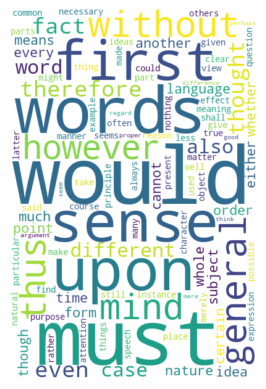

In [95]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wc = WordCloud(background_color='white', width=400, height=600)
wordcloud = wc.generate_from_frequencies(dict(mdl.get_topic_words(0, top_n=100)))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")


In [110]:
dfmeta.iloc[0]

source_id                                           mdp.39015050663247
group_id_s                                          mdp.39015050663247
source_t                                                  [HathiTrust]
source_url              https://hdl.handle.net/2027/mdp.39015050663247
title                           The imperial encyclopaedic dictionary;
subtitle             a new and exhaustive work of reference to the ...
sort_title           imperial encyclopaedic dictionary; a new and e...
pub_date                                                        1901.0
pub_place                                                       London
publisher                                Dictionary and Cyclopedia Co.
enumcron                                                           v.2
author                                       Hunter, Robert, 1823-1897
author_exact                                 Hunter, Robert, 1823-1897
collections                                             [Dictionaries]
collec

In [168]:
import altair as alt
from ipywidgets import interactive, interact, interact_manual, HBox

tnums=list(range(mdl.k))
topicwords_d = {tnum:', '.join([i for i,j in mdl.get_topic_words(tnum)]) for tnum in tnums}
topicnames = [f'{tnum}: {topicwords_d[tnum]}' for tnum in tnums]

def get_wordcloud(tnum):
    wc = WordCloud(background_color='white', width=1200, height=200)
    wordcloud = wc.generate_from_frequencies(dict(mdl.get_topic_words(tnum, top_n=100)))
    return wordcloud

@interact(tname=topicnames)
def plot_topic(tname):
    tnum=int(tname.split(':')[0])
    collections={'Linguistic','Literary'}
    figdf=dfclust.reset_index()[[CLUSTER_KEY,'title','author','pub_date','publisher','pub_place','source_url', 'collections', tnum]]
    figdf['collections']=[[x for x in c if x in collections] for c in figdf.collections]
    figdf['collections'] = figdf['collections'].apply(lambda x: 'Linguistic' if 'Linguistic' in set(x) else (x[0] if x else x))
    figdf=figdf[figdf.collections.apply(bool)]
    figdf.columns = ['cluster', 'title', 'author', 'date', 'publisher', 'pubplace', 'source', 'genre', 'topic']
    figdf = figdf[1700<=figdf.date]

    topicwords = topicwords_d.get(tnum)
    wordcloud=get_wordcloud(tnum)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")

    
    fig = alt.Chart(figdf).mark_circle(size=60).encode(
        x = alt.X('date', scale=alt.Scale(domain=[1700, 1920])),
        y='topic',
        color='genre',
        tooltip=figdf.columns.tolist()
    ).interactive(
    ).properties(
        width=800,
        height=400,
    # ).facet(
    #     facet='genre:N',
    #     columns=2,
    # ).resolve_scale(
    #     y='independent'
    ).properties(
        title = f'Topic {tnum}: {topicwords}'
    )
    return fig

interactive(children=(Dropdown(description='tname', options=('0: would, must, words, upon, sense, first, witho…

In [146]:
from string import punctuation

def get_cluster_name(clustid):
    meta = dict(dfclust_meta.loc[clustid])
    return f'{meta["title"].strip(punctuation)[:50]} ({str(meta["pub_date"])[:4]}) [{meta["source_url"]}]'

In [169]:
get_cluster_name('mdp.39015050663247')

'The imperial encyclopaedic dictionary (1901) [https://hdl.handle.net/2027/mdp.39015050663247]'

In [189]:
def save_wordclouds(odir='wordclouds'):
    my_dpi=75
    os.makedirs(odir, exist_ok=True)
    for tnum in tqdm(list(range(mdl.k)), desc='Saving wordclouds'):
        wordcloud=get_wordcloud(tnum)
        plt.box(False)
        plt.figure(figsize=(600/my_dpi, 200/my_dpi), dpi=my_dpi)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.savefig(f'{odir}/fig.wordcloud.tnum={tnum}.png')

In [196]:
# save_wordclouds()

In [191]:
def geturl(tnum):
    return f'https://raw.githubusercontent.com/Princeton-CDH/ppa-nlp/96d20d8d5537aee5fd7a8da6420665bdda358940/notebooks/wordclouds/fig.wordcloud.tnum%3D{tnum}.png'

def get_topic_info_df():
    tld=[]
    for tnum in tqdm(list(range(mdl.k)), desc='Gathering info on topics'):
        td={
            'Topic':tnum,
            'Topic Name':'',
            'Top Words':', '.join([i for i,j in mdl.get_topic_words(tnum, top_n=50)]),
            'Top Documents':'* '+('\n* '.join(get_cluster_name(c) for c in dfclust.sort_values(tnum,ascending=False).index[:5])),
            'Word Cloud':f'=IMAGE("{geturl(tnum)}")'

        }
        tld.append(td)
    tdf=pd.DataFrame(tld).set_index('Topic')
    return tdf

In [192]:
tdf=get_topic_info_df()

Gathering info on topics: 100%|██████████| 50/50 [00:01<00:00, 29.16it/s]


In [195]:
!pip install openpyxl
tdf.to_excel('data.topic_info.xlsx')

  Using cached openpyxl-3.1.2-py2.py3-none-any.whl (249 kB)
  Using cached et_xmlfile-1.1.0-py3-none-any.whl (4.7 kB)
